In [12]:
# Step 1: Import libraries
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam



In [1]:
import tensorflow as tf

# Check if GPU is available
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print("GPUs found:", gpus)
else:
    print("No GPU found, using CPU")

# Optional: Set memory growth to prevent TensorFlow from grabbing all GPU memory
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

2026-01-08 04:59:14.930556: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1767848355.334748      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1767848355.444564      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1767848356.379168      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1767848356.379229      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1767848356.379232      55 computation_placer.cc:177] computation placer alr

GPUs found: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


In [4]:
# Step 2: Set dataset paths
TRAIN_DIR = "/kaggle/input/brain-tumor-mri-dataset/Training"  # Change this to your Kaggle path
TEST_DIR  = "/kaggle/input/brain-tumor-mri-dataset/Testing"   # Change this to your Kaggle path

# Quick check: classes
print("Training classes:", os.listdir(TRAIN_DIR))
print("Testing classes:", os.listdir(TEST_DIR))

Training classes: ['pituitary', 'notumor', 'meningioma', 'glioma']
Testing classes: ['pituitary', 'notumor', 'meningioma', 'glioma']


In [5]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# Training generator with augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,  # augmentation
    width_shift_range=0.1,  # augmentation
    height_shift_range=0.1,  # augmentation
    shear_range=0.1,  # augmentation
    zoom_range=0.1,  # augmentation
    horizontal_flip=True,  # augmentation
    fill_mode='nearest',  # augmentation
    validation_split=0.2  # 20% data will be used for validation
)

# Training subset
train_gen = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    subset='training'   # <-- training data
)

# Validation subset
val_gen = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False,
    subset='validation'  # <-- validation data
)


Found 4571 images belonging to 4 classes.
Found 1141 images belonging to 4 classes.


In [6]:

# Step 4: Build ResNet50 model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224,224,3))

# Unfreezed some layers of ResNet50
base_model.trainable = True

for layer in base_model.layers[:-30]:
    layer.trainable = False

# Add custom top layers
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.3),               # reduce overfitting
    Dense(4, activation='softmax')  # 4 classes
])

# Compile model
model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


I0000 00:00:1767848395.093829      55 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1767848395.097815      55 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4)              │         8,196 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,595,908 (90.01 MB)

 Trainable params: 14,458,372 (55.15 MB)

 Non-trainable params: 9,137,536 (34.86 MB)

In [7]:
# Step 5: Train the model
EPOCHS = 25

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS
)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25


I0000 00:00:1767848428.624026     139 service.cc:152] XLA service 0x7caa68017300 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1767848428.624063     139 service.cc:160]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1767848428.624069     139 service.cc:160]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1767848431.072823     139 cuda_dnn.cc:529] Loaded cuDNN version 91002


  1/143 ━━━━━━━━━━━━━━━━━━━━ 51:32 22s/step - accuracy: 0.1562 - loss: 1.6898

I0000 00:00:1767848440.281719     139 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


143/143 ━━━━━━━━━━━━━━━━━━━━ 126s 735ms/step - accuracy: 0.5668 - loss: 0.9955 - val_accuracy: 0.3751 - val_loss: 1.2783
Epoch 2/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 65s 456ms/step - accuracy: 0.7117 - loss: 0.6745 - val_accuracy: 0.6240 - val_loss: 0.9118
Epoch 3/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 65s 456ms/step - accuracy: 0.7605 - loss: 0.5968 - val_accuracy: 0.7160 - val_loss: 0.7559
Epoch 4/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 65s 453ms/step - accuracy: 0.7788 - loss: 0.5504 - val_accuracy: 0.6915 - val_loss: 0.8445
Epoch 5/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 65s 454ms/step - accuracy: 0.7826 - loss: 0.5286 - val_accuracy: 0.7160 - val_loss: 0.7538
Epoch 6/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 64s 449ms/step - accuracy: 0.7878 - loss: 0.5283 - val_accuracy: 0.7038 - val_loss: 0.8413
Epoch 7/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 67s 466ms/step - accuracy: 0.8108 - loss: 0.4757 - val_accuracy: 0.7230 - val_loss: 0.7491
Epoch 8/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 66s 462ms/step - accuracy: 0.8139 - loss: 0.4713 - va

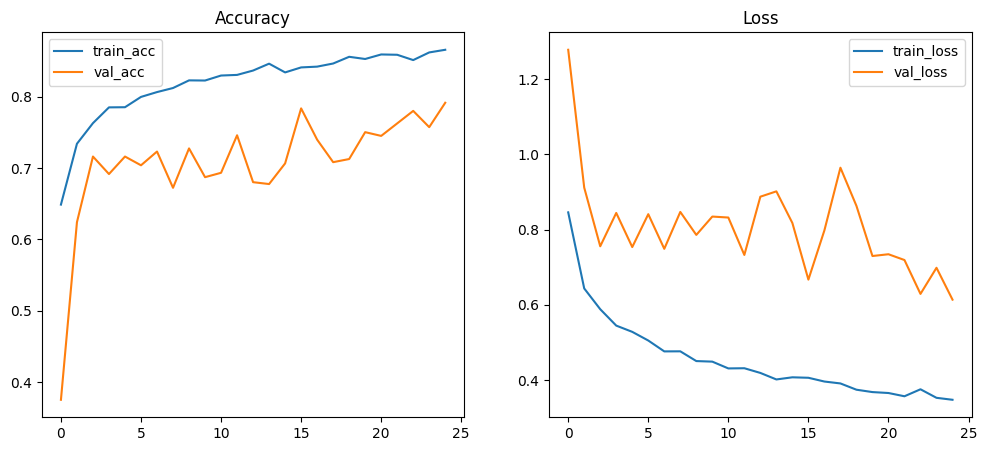

In [8]:
# Step 6: Plot training history
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.title("Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title("Loss")
plt.legend()

plt.show()

# =========================
# Step: Evaluate on Test Data
# =========================


In [11]:
# Test data generator (only rescale, no augmentation)
test_datagen = ImageDataGenerator(rescale=1./255)

test_gen = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=IMG_SIZE,   # e.g., (224,224)
    batch_size=BATCH_SIZE,
    class_mode='categorical', # because this is multi-class
    shuffle=False             # important! do NOT shuffle for test
)

test_loss, test_acc = model.evaluate(test_gen)
print("Final Test Accuracy:", test_acc)
print("Final Test Loss:", test_loss)


Found 1311 images belonging to 4 classes.
41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 87ms/step - accuracy: 0.6556 - loss: 0.9893
Final Test Accuracy: 0.8001525402069092
Final Test Loss: 0.6018060445785522


# ======================================
# Inference (Test on single image)
# ======================================

In [44]:
# Path to a single test image
img_path = "/kaggle/input/brain-tumor-mri-dataset/Testing/meningioma/Te-me_0015.jpg"  # change this

# Load & resize
img = image.load_img(img_path, target_size=IMG_SIZE)

# Convert to array
img_array = image.img_to_array(img)

# SAME preprocessing as test data
img_array = img_array / 255.0

# Add batch dimension
img_array = np.expand_dims(img_array, axis=0)


In [45]:
pred = model.predict(img_array)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


In [46]:
class_names = list(test_gen.class_indices.keys())

predicted_class = class_names[np.argmax(pred)]
confidence = np.max(pred)

print("Predicted Class:", predicted_class)
print("Confidence:", confidence)


Predicted Class: notumor
Confidence: 0.99047756


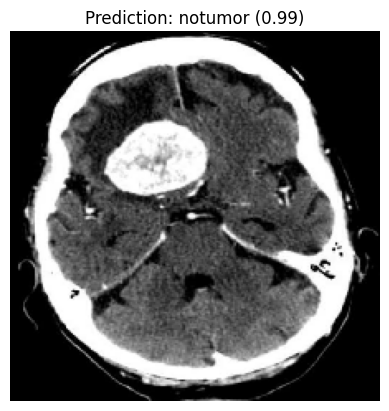

In [43]:
plt.imshow(img)
plt.axis("off")
plt.title(f"Prediction: {predicted_class} ({confidence:.2f})")
plt.show()
